In [55]:
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'
from tqdm import tqdm
import re
import spacy


# Read File

In [56]:
dir = "data/newsrelease_B-1-100_C-1-4/"
file_path = dir + "B-1.txt"

with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()
sentences = re.split(r'\n+', text)

# Load NLP Model

In [57]:
# nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('ja_core_news_sm')
doc = nlp("DNP久喜工場の製造ラインを一部移管し、読者の需要に応じた商品供給を強化")
for tok in doc:
    print(tok.text, "...", tok.dep_)

DNP ... compound
久喜 ... compound
工場 ... nmod
の ... case
製造 ... compound
ライン ... obj
を ... case
一部 ... advmod
移管 ... advcl
し ... aux
、 ... punct
読者 ... nmod
の ... case
需要 ... obl
に ... case
応じ ... acl
た ... aux
商品 ... compound
供給 ... obj
を ... case
強化 ... ROOT


# Entity Pairs Extraction

In [58]:
def get_entities(sentence):
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    for tok in nlp(sentence):
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + tok.text

            # # check: token is a modifier or not
            # if tok.dep_.endswith("mod"):
            #     modifier = tok.text
            #     # if the previous word was also a 'compound' then add the current word to it
            #     if prv_tok_dep == "compound":
            #         modifier = prv_tok_text + tok.text

            if "subj" in tok.dep_:
                # ent1 = modifier + prefix + tok.text
                ent1 = prefix + tok.text
                prefix = ""
                # modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

            if "obj" in tok.dep_:
                # ent2 = modifier + prefix + tok.text
                ent2 = prefix + tok.text

            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.strip(), ent2.strip()]

In [59]:
get_entities("DNP久喜工場の製造ラインを一部移管し、読者の需要に応じた商品供給を強化")

['', '商品供給']

In [60]:
entity_pairs = []
for i in tqdm(sentences):
    entity_pairs.append(get_entities(i))
entity_pairs[:10]

100%|██████████| 48/48 [00:00<00:00, 119.60it/s]


[['', ''],
 ['', '製造ライン導入'],
 ['', '商品供給'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', '']]

# Relation / Predicate Extraction


In [61]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = spacy.matcher.Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern], on_match = None) 

    matches = matcher(doc)

    if len(matches) > 0: 
        k = len(matches) - 1 
        span = doc[matches[k][1]:matches[k][2]] 
        return(span.text)
    else: 
        return None

In [62]:
get_relation("私はご飯を食べる。")


'食べる'

In [63]:
relations = [get_relation(i) for i in tqdm(sentences)]
pd.Series(relations).value_counts()[:10]


100%|██████████| 48/48 [00:00<00:00, 117.95it/s]


強化     3
目指し    3
価値     3
向上     2
創出     2
日      1
短縮     1
）      1
増大     1
対応     1
dtype: int64

# Build a Knowledge Graph


In [64]:
# extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

如何处理：pd.DataFrame({'source':source, 'target':target, 'edge':relations})中source，target和edge中任何一项为空字符串时则删除对应的source，target和edge

,source,target,edge
0,,,日
1,,製造ライン導入,目指す
2,,商品供給,強化
3,,,リリース
4,,,サービス
5,,,教育
6,,,加工
7,,,プロモーション
8,,,DX
9,,,コラボレーション


# Draw Complete Graph

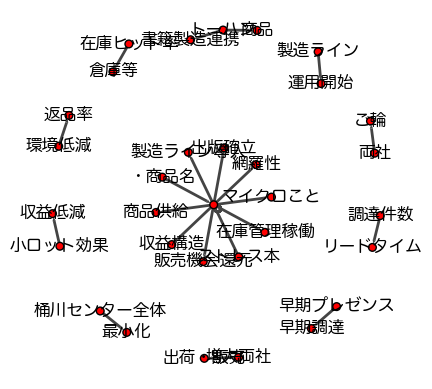

In [65]:
# create a directed-graph from a dataframe (network)
# G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
# plt.figure(figsize=(12,12))
# pos = nx.spring_layout(G)
# nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
# plt.show()

# igraph
G = ig.Graph.DataFrame(kg_df, directed=True, use_vids=False)
fig, ax = plt.subplots()
ig.plot(G, target=ax, vertex_color="red", vertex_label=G.vs["name"])
plt.show()

# Draw Specific Graph

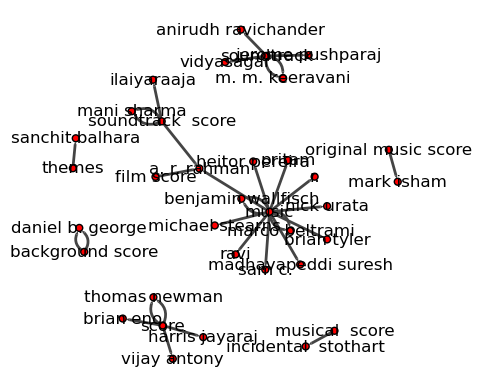

In [13]:
# # networkx
# G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
# plt.figure(figsize=(12,12))
# pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
# nx.draw_networkx(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
# plt.show()

# igraph
G = ig.Graph.DataFrame(kg_df[kg_df['edge']=="composed by"], directed=True, use_vids=False)
fig, ax = plt.subplots()
ig.plot(G, target=ax, vertex_color="red", vertex_label=G.vs["name"])
plt.show()

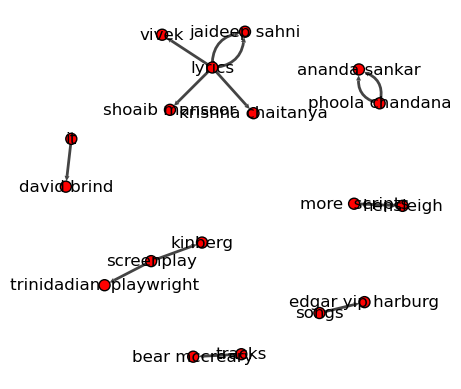

In [14]:
# # networkx
# G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
# plt.figure(figsize=(12,12))
# pos = nx.spring_layout(G, k = 0.5)
# nx.draw_networkx(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
# plt.show()

# igraph
G = ig.Graph.DataFrame(kg_df[kg_df['edge']=="written by"], directed=True, use_vids=False)
fig, ax = plt.subplots()
ig.plot(G, target=ax, vertex_color="red", vertex_label=G.vs["name"])
plt.show()

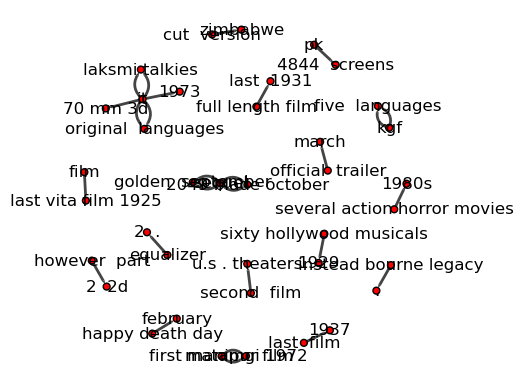

In [15]:
# # networkx
# G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
# plt.figure(figsize=(12,12))
# pos = nx.spring_layout(G, k = 0.5)
# nx.draw_networkx(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
# plt.show()

# igraph
G = ig.Graph.DataFrame(kg_df[kg_df['edge']=="released in"], directed=True, use_vids=False)
fig, ax = plt.subplots()
ig.plot(G, target=ax, vertex_color="red", vertex_label=G.vs["name"])
plt.show()